In [31]:
import argparse
from dataclasses import dataclass
from typing import Any, Optional
from scipy.stats import ortho_group
import argparse
import itertools
import os
import pickle
from collections.abc import Generator
from dataclasses import dataclass, field
from datetime import datetime
from typing import Any, List, Optional, Tuple, Union

import numpy as np
import numpy.typing as npt
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
from torchtyping import TensorType
from tqdm import tqdm

In this notebook, we look at how sparse autoencoding understands transitions between features. 

We're going to define a random toy dataset made from sparse linear combinations of features. Then we're going to make a 2nd dataset by transforming every datapoint in the first dataset. 

Then we'll train two sparse autoencoders, one on the original dataset, and one on the dataset that has undergone a linear transformation. 

Then we'll look at the relationship between the learned features. There should be a one-to-one relationship between them if the method is to be similar to RIB. 

# Define configs

In [32]:
@dataclass
class ToyArgs():
    device: str = "cuda:0" if torch.cuda.is_available() else "cpu"
    tied_ae: bool = False
    seed: int = 0
    learned_dict_ratio: float = 1.0
    output_folder: str = "outputs"
    dtype: torch.dtype = torch.float32
    activation_dim: int = 32
    feature_prob_decay: float = 0.99
    feature_num_nonzero: int = 8
    correlated_components: bool = False
    n_ground_truth_components: int = 32
    batch_size: int = 4096
    lr: float = 2e-3
    epochs: int = 50000
    n_components_dictionary: int = 64
    n_components_dictionary_trans: int = 64
    l1_alpha: float = 5e-3
    p: float = 0.5 # the p in the L_p norm used to induce sparsity

# Define data generators and autoencoders

In [33]:

@dataclass
class RandomDatasetGenerator(Generator):
    activation_dim: int
    n_ground_truth_components: int
    batch_size: int
    feature_num_nonzero: int
    feature_prob_decay: float
    correlated: bool
    device: Union[torch.device, str]

    frac_nonzero: float = field(init=False)
    decay: TensorType["n_ground_truth_components"] = field(init=False)
    feats: TensorType["n_ground_truth_components", "activation_dim"] = field(init=False)
    corr_matrix: Optional[TensorType["n_ground_truth_components", "n_ground_truth_components"]] = field(init=False)
    component_probs: Optional[TensorType["n_ground_truth_components"]] = field(init=False)

    def __post_init__(self):
        self.frac_nonzero = self.feature_num_nonzero / self.n_ground_truth_components

        # Define the probabilities of each component being included in the data
        self.decay = torch.tensor([self.feature_prob_decay**i for i in range(self.n_ground_truth_components)]).to(
            self.device
        )  # FIXME: 1 / i

        self.component_probs = self.decay * self.frac_nonzero  # Only if non-correlated
        self.feats = generate_rand_feats(
            self.activation_dim,
            self.n_ground_truth_components,
            device=self.device,
        )

    def send(self, ignored_arg: Any) -> TensorType["dataset_size", "activation_dim"]:
        _, _, data = generate_rand_dataset(
            self.n_ground_truth_components,
            self.batch_size,
            self.component_probs,
            self.feats,
            self.device,
        )
        return data

    def throw(self, type: Any = None, value: Any = None, traceback: Any = None) -> None:
        raise StopIteration


def generate_rand_dataset(
    n_ground_truth_components: int,  #
    dataset_size: int,
    feature_probs: TensorType["n_ground_truth_components"],
    feats: TensorType["n_ground_truth_components", "activation_dim"],
    device: Union[torch.device, str],
) -> Tuple[
    TensorType["n_ground_truth_components", "activation_dim"],
    TensorType["dataset_size", "n_ground_truth_components"],
    TensorType["dataset_size", "activation_dim"],
]:
    # generate random feature strengths
    feature_strengths = torch.rand((dataset_size, n_ground_truth_components), device=device)
    # only some features are activated, chosen at random
    dataset_thresh = torch.rand(dataset_size, n_ground_truth_components, device=device)
    data_zero = torch.zeros_like(dataset_thresh, device=device)

    dataset_codes = torch.where(
        dataset_thresh <= feature_probs,
        feature_strengths,
        data_zero,
    )  # dim: dataset_size x n_ground_truth_components

    dataset = dataset_codes @ feats

    return feats, dataset_codes, dataset


def generate_rand_feats(
    feat_dim: int,
    num_feats: int,
    device: Union[torch.device, str],
) -> TensorType["n_ground_truth_components", "activation_dim"]:
    data_path = os.path.join(os.getcwd(), "data")
    data_filename = os.path.join(data_path, f"feats_{feat_dim}_{num_feats}.npy")

    feats = np.random.multivariate_normal(np.zeros(feat_dim), np.eye(feat_dim), size=num_feats)
    feats = feats.T / np.linalg.norm(feats, axis=1)
    feats = feats.T

    feats_tensor = torch.from_numpy(feats).to(device).float()
    return feats_tensor


# AutoEncoder Definition
class AutoEncoder(nn.Module):
    def __init__(self, activation_size, n_dict_components):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(nn.Linear(activation_size, n_dict_components), nn.ReLU())
        self.decoder = nn.Linear(n_dict_components, activation_size, bias=False)

        # Initialize the decoder weights orthogonally
        nn.init.orthogonal_(self.decoder.weight)

    def forward(self, x):
        c = self.encoder(x)

        # Apply unit norm constraint to the decoder weights
        self.decoder.weight.data = nn.functional.normalize(self.decoder.weight.data, dim=0)

        x_hat = self.decoder(c)
        return x_hat, c

    @property
    def device(self):
        return next(self.parameters()).device


def cosine_sim(
    vecs1: Union[torch.Tensor, torch.nn.parameter.Parameter, npt.NDArray],
    vecs2: Union[torch.Tensor, torch.nn.parameter.Parameter, npt.NDArray],
) -> np.ndarray:
    vecs = [vecs1, vecs2]
    for i in range(len(vecs)):
        if not isinstance(vecs[i], np.ndarray):
            vecs[i] = vecs[i].detach().cpu().numpy()  # type: ignore
    vecs1, vecs2 = vecs
    normalize = lambda v: (v.T / np.linalg.norm(v, axis=1)).T
    vecs1_norm = normalize(vecs1)
    vecs2_norm = normalize(vecs2)

    return vecs1_norm @ vecs2_norm.T


def mean_max_cosine_similarity(ground_truth_features, learned_dictionary, debug=False):
    # Calculate cosine similarity between all pairs of ground truth and learned features
    cos_sim = cosine_sim(ground_truth_features, learned_dictionary)
    # Find the maximum cosine similarity for each ground truth feature, then average
    mmcs = cos_sim.max(axis=1).mean()
    return mmcs

def calculate_mmcs(auto_encoder, ground_truth_features):
    learned_dictionary = auto_encoder.decoder.weight.data.t()
    with torch.no_grad():
        mmcs = mean_max_cosine_similarity(ground_truth_features.to(auto_encoder.device), learned_dictionary)
    return mmcs


def get_n_dead_neurons(auto_encoder, data_generator, n_batches=10):
    """
    :param result_dict: dictionary containing the results of a single run
    :return: number of dead neurons

    Estimates the number of dead neurons in the network by running a few batches of data through the network and
    calculating the mean activation of each neuron. If the mean activation is 0 for a neuron, it is considered dead.
    """
    outputs = []
    for i in range(n_batches):
        batch = next(data_generator)
        x_hat, c = auto_encoder(batch)  # x_hat: (batch_size, activation_dim), c: (batch_size, n_dict_components)
        outputs.append(c)
    outputs = torch.cat(outputs)  # (n_batches * batch_size, n_dict_components)
    mean_activations = outputs.mean(dim=0)  # (n_dict_components), c is after the ReLU, no need to take abs
    n_dead_neurons = (mean_activations == 0).sum().item()
    return n_dead_neurons


# Instantiate the autoencoders, optimizers, datasets, linear transformation, and transcoder

In [34]:
cfg = ToyArgs()
cfg.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(cfg.seed)
np.random.seed(cfg.seed)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_generator = RandomDatasetGenerator(
    activation_dim=cfg.activation_dim,
    n_ground_truth_components=cfg.n_ground_truth_components,
    batch_size=cfg.batch_size,
    feature_num_nonzero=cfg.feature_num_nonzero,
    feature_prob_decay=cfg.feature_prob_decay,
    correlated=cfg.correlated_components,
    device=device,
)

auto_encoder1 = AutoEncoder(cfg.activation_dim, cfg.n_components_dictionary).to(device)
auto_encoder2 = AutoEncoder(cfg.activation_dim, cfg.n_components_dictionary).to(device)
#trans_coder = AutoEncoder(cfg.n_components_dictionary, cfg.n_components_dictionary_trans).to(device)
trans_coder = nn.Linear(cfg.n_components_dictionary, cfg.n_components_dictionary, bias=False).to(device)

optimizer1 = optim.Adam(auto_encoder1.parameters(), lr=cfg.lr)
optimizer2 = optim.Adam(auto_encoder2.parameters(), lr=cfg.lr)
optimizer_trans = optim.Adam(trans_coder.parameters(), lr=cfg.lr)


ground_truth_features = data_generator.feats


# We choose a random orthogonal matrix to initialize the transformation matrix. 
# Why orthogonal? So that the null space of the transformation matrix is empty, meaning
# that the features found in the first layer are not lost in the second layer. This is just for demonstration purposes.
# In practice the approach would be able to cope if some of the features get lost during the transformation
# because there would just be fewer features in the second layer (i.e. more 'dead' features)
M = ortho_group.rvs(dim=cfg.activation_dim)
M = torch.from_numpy(M).to(device).float()



# Train the two SAEs: One on the data and the other on the linearly transformed data

In [35]:

for epoch in range(cfg.epochs):

    # for batch_index in range(dataset_size // batch_size):
    # Generate a batch of samples
    # batch = final_dataset[batch_index*batch_size:(batch_index+1)*batch_size].to(device)
    # batch = create_dataset(ground_truth_features, probabilities, batch_size).float().to(device)
    batch = next(data_generator)
    Mbatch = batch @ M
    # batch = batch + cfg.noise_level * torch.randn_like(batch)

    optimizer1.zero_grad()
    optimizer2.zero_grad()

    # Forward pass
    x_hat1, c1 = auto_encoder1(batch)
    x_hat2, c2 = auto_encoder2(Mbatch)

    # Compute the reconstruction loss and L1 regularization
    l_reconstruction_1 = torch.nn.MSELoss()(batch, x_hat1)
    l_l1_1 = cfg.l1_alpha * torch.norm(c1, cfg.p, dim=1).mean() / c1.size(1)

    l_reconstruction_2 = torch.nn.MSELoss()(Mbatch, x_hat2)
    l_l1_2 = cfg.l1_alpha * torch.norm(c2, cfg.p, dim=1).mean() / c2.size(1)

    # Print the losses, mmcs, and current epoch
    if (epoch + 1) % 10 == 0:
        # Calculate MMCS
        mmcs1 = calculate_mmcs(auto_encoder1, ground_truth_features)
        mmcs2 = calculate_mmcs(auto_encoder2, ground_truth_features @ M)
        # Print the losses, mmcs for both autoencoders 1 and 2 in the same line
        print(f"Epoch {epoch+1}/{cfg.epochs}: Reconstruction1 = {l_reconstruction_1:.6f} | l1_1: {l_l1_1:.6f} | MMCS_1: {mmcs1:.3f} | Reconstruction_2 = {l_reconstruction_2:.6f} | l1_2: {l_l1_2:.6f} | MMCS_2: {mmcs2:.3f}")

    # Compute the total loss
    loss1 = l_reconstruction_1 + l_l1_1
    loss2 = l_reconstruction_2 + l_l1_2

    # Backward pass
    loss1.backward()
    loss2.backward()

    optimizer1.step()
    optimizer2.step()

learned_dictionary1 = auto_encoder1.decoder.weight.data.t()
learned_dictionary2 = auto_encoder2.decoder.weight.data.t()
mmcs1 = mean_max_cosine_similarity(ground_truth_features.to(auto_encoder1.device), learned_dictionary1)
mmcs2 = mean_max_cosine_similarity(ground_truth_features.to(auto_encoder2.device), learned_dictionary2)
n_dead_neurons1 = get_n_dead_neurons(auto_encoder1, data_generator)
n_dead_neurons2 = get_n_dead_neurons(auto_encoder2, data_generator)

Epoch 10/50000: Reconstruction1 = 0.067200 | l1_1: 0.006064 | MMCS_1: 0.417 | Reconstruction_2 = 0.077773 | l1_2: 0.007416 | MMCS_2: 0.411
Epoch 20/50000: Reconstruction1 = 0.049085 | l1_1: 0.005040 | MMCS_1: 0.421 | Reconstruction_2 = 0.054886 | l1_2: 0.005501 | MMCS_2: 0.421
Epoch 30/50000: Reconstruction1 = 0.038080 | l1_1: 0.005383 | MMCS_1: 0.430 | Reconstruction_2 = 0.042349 | l1_2: 0.005552 | MMCS_2: 0.430
Epoch 40/50000: Reconstruction1 = 0.029768 | l1_1: 0.006138 | MMCS_1: 0.444 | Reconstruction_2 = 0.034017 | l1_2: 0.006045 | MMCS_2: 0.440
Epoch 50/50000: Reconstruction1 = 0.023837 | l1_1: 0.006826 | MMCS_1: 0.462 | Reconstruction_2 = 0.027631 | l1_2: 0.006693 | MMCS_2: 0.453
Epoch 60/50000: Reconstruction1 = 0.019008 | l1_1: 0.007335 | MMCS_1: 0.479 | Reconstruction_2 = 0.021976 | l1_2: 0.007352 | MMCS_2: 0.467
Epoch 70/50000: Reconstruction1 = 0.015628 | l1_1: 0.007574 | MMCS_1: 0.495 | Reconstruction_2 = 0.017654 | l1_2: 0.007934 | MMCS_2: 0.480
Epoch 80/50000: Reconstruct

Epoch 260/50000: Reconstruction1 = 0.005700 | l1_1: 0.005705 | MMCS_1: 0.638 | Reconstruction_2 = 0.005790 | l1_2: 0.005935 | MMCS_2: 0.642
Epoch 270/50000: Reconstruction1 = 0.005552 | l1_1: 0.005650 | MMCS_1: 0.643 | Reconstruction_2 = 0.005704 | l1_2: 0.005880 | MMCS_2: 0.649
Epoch 280/50000: Reconstruction1 = 0.005437 | l1_1: 0.005559 | MMCS_1: 0.649 | Reconstruction_2 = 0.005606 | l1_2: 0.005775 | MMCS_2: 0.655
Epoch 290/50000: Reconstruction1 = 0.005313 | l1_1: 0.005548 | MMCS_1: 0.655 | Reconstruction_2 = 0.005473 | l1_2: 0.005711 | MMCS_2: 0.661
Epoch 300/50000: Reconstruction1 = 0.005184 | l1_1: 0.005486 | MMCS_1: 0.660 | Reconstruction_2 = 0.005352 | l1_2: 0.005640 | MMCS_2: 0.667
Epoch 310/50000: Reconstruction1 = 0.005101 | l1_1: 0.005421 | MMCS_1: 0.666 | Reconstruction_2 = 0.005272 | l1_2: 0.005625 | MMCS_2: 0.673
Epoch 320/50000: Reconstruction1 = 0.005033 | l1_1: 0.005338 | MMCS_1: 0.671 | Reconstruction_2 = 0.005179 | l1_2: 0.005515 | MMCS_2: 0.679
Epoch 330/50000: Rec

# Now train the transcoder to map from the first autoencoder's feature activations to the second's


Here we're using a linear transcoder. If we expected there to be nonlinear interactions between features in SAE1 and SAE2, then we might consider using another SAE for the transcoder. But here, since there is just a linear transformation of the data, we should be able to describe the relationship using only a linear transcoder.

In [36]:

for epoch in range(int(cfg.epochs*0.2)):

    # for batch_index in range(dataset_size // batch_size):
    # Generate a batch of samples
    batch = next(data_generator)
    Mbatch = batch @ M

    optimizer_trans.zero_grad()

    # Forward pass of each autoencoder and the transcoder
    with torch.no_grad():
        x_hat1, c1 = auto_encoder1(batch)
        x_hat2, c2 = auto_encoder2(Mbatch)
    
    # If SAE transcoder
    #c2_hat, c_trans = trans_coder(c1)

    # If linear transcoder
    c2_hat = trans_coder(c1)

    # Compute the reconstruction loss and L1 regularization
    l_reconstruction_trans = torch.nn.MSELoss()(c2, c2_hat)
    
    
    # If SAE transcoder
    #l_l1_trans = cfg.l1_alpha * torch.norm(c_trans, 1., dim=1).mean() / c_trans.size(1)

    # If linear transcoder, L1 penalty on the transcoder weights
    l_l1_trans = cfg.l1_alpha * sum(torch.linalg.norm(p, 1) for p in trans_coder.parameters())
    
    # Print the losses, mmcs, and current epoch
    if (epoch + 1) % 10 == 0:
        # If linear transcoder
        print(f"Epoch {epoch+1}/{cfg.epochs}: Reconstruction = {l_reconstruction_trans:.6f} | l1: {l_l1_trans:.6f}")

        # # Calculate MMCS
        # learned_dictionary = trans_coder.decoder.weight.data.t()
        # with torch.no_grad():
        #     mmcs_trans = mean_max_cosine_similarity(ground_truth_features.to(trans_coder.device), learned_dictionary)
        # print(f"Epoch {epoch+1}/{cfg.epochs}: Reconstruction = {l_reconstruction_trans:.6f} | l1: {l_l1_trans:.6f} | MMCS: {mmcs_trans:.3f}")
    
    # Compute the total loss
    loss_trans = l_reconstruction_trans + l_l1_trans

    # Backward pass
    loss_trans.backward()

    optimizer_trans.step()


Epoch 10/50000: Reconstruction = 0.037575 | l1: 0.021865
Epoch 20/50000: Reconstruction = 0.032340 | l1: 0.020358
Epoch 30/50000: Reconstruction = 0.029713 | l1: 0.019355
Epoch 40/50000: Reconstruction = 0.027113 | l1: 0.018451
Epoch 50/50000: Reconstruction = 0.025541 | l1: 0.017337
Epoch 60/50000: Reconstruction = 0.023631 | l1: 0.016423
Epoch 70/50000: Reconstruction = 0.022576 | l1: 0.015208
Epoch 80/50000: Reconstruction = 0.021338 | l1: 0.014670
Epoch 90/50000: Reconstruction = 0.020265 | l1: 0.013920
Epoch 100/50000: Reconstruction = 0.019357 | l1: 0.012823
Epoch 110/50000: Reconstruction = 0.018440 | l1: 0.012106
Epoch 120/50000: Reconstruction = 0.017713 | l1: 0.011447
Epoch 130/50000: Reconstruction = 0.017017 | l1: 0.010632
Epoch 140/50000: Reconstruction = 0.016167 | l1: 0.009857
Epoch 150/50000: Reconstruction = 0.015376 | l1: 0.009311
Epoch 160/50000: Reconstruction = 0.014868 | l1: 0.008532
Epoch 170/50000: Reconstruction = 0.014016 | l1: 0.007998
Epoch 180/50000: Recons

Epoch 220/50000: Reconstruction = 0.010951 | l1: 0.005227
Epoch 230/50000: Reconstruction = 0.010594 | l1: 0.005211
Epoch 240/50000: Reconstruction = 0.010213 | l1: 0.006218
Epoch 250/50000: Reconstruction = 0.010269 | l1: 0.008381
Epoch 260/50000: Reconstruction = 0.010403 | l1: 0.006427
Epoch 270/50000: Reconstruction = 0.009545 | l1: 0.005489
Epoch 280/50000: Reconstruction = 0.008846 | l1: 0.005574
Epoch 290/50000: Reconstruction = 0.008224 | l1: 0.005769
Epoch 300/50000: Reconstruction = 0.007933 | l1: 0.005977
Epoch 310/50000: Reconstruction = 0.007757 | l1: 0.005636
Epoch 320/50000: Reconstruction = 0.007407 | l1: 0.005523
Epoch 330/50000: Reconstruction = 0.006930 | l1: 0.005548
Epoch 340/50000: Reconstruction = 0.006708 | l1: 0.005160
Epoch 350/50000: Reconstruction = 0.006370 | l1: 0.005266
Epoch 360/50000: Reconstruction = 0.005993 | l1: 0.005274
Epoch 370/50000: Reconstruction = 0.005650 | l1: 0.005274
Epoch 380/50000: Reconstruction = 0.005463 | l1: 0.005341
Epoch 390/5000

# Plot the linear transcoder matrix. 


Note that most elements are close to zero (due to the L1 penalty on the weights) except usually for one large one. 

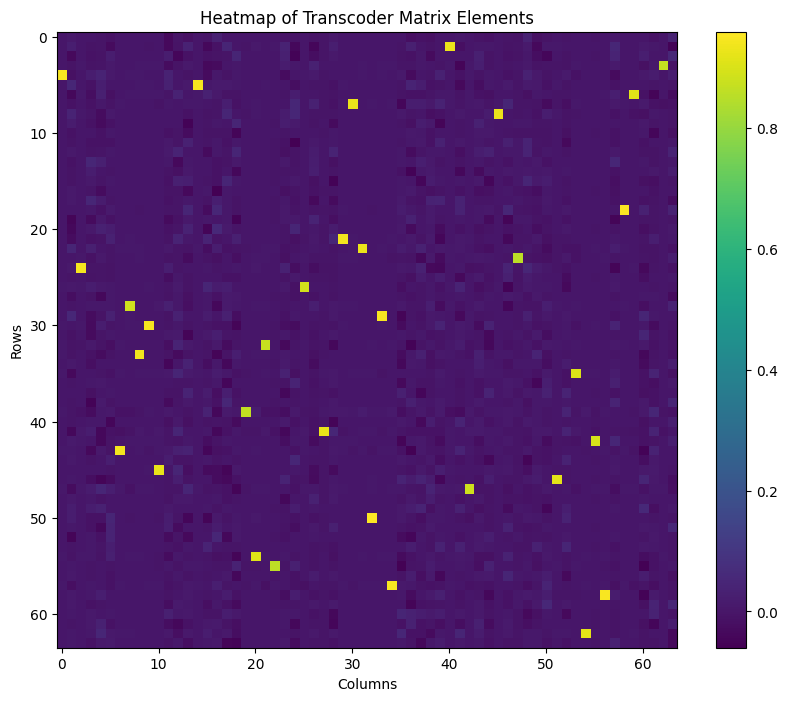

In [37]:

# Get transcoder matrix
trans_mat = [p for p in trans_coder.parameters()][0].detach().cpu().numpy()

# Plot a heatmap of the transcoder matrix elements with matplotlib

plt.figure(figsize=(10, 8))
plt.imshow(trans_mat, cmap='viridis', aspect='auto')
plt.colorbar()
plt.title("Heatmap of Transcoder Matrix Elements")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()

If we sort the columns according to their largest row index, then we see a nice arrangement, making the approximately one-to-one relationship between SAE1 features and SAE2 features clearer:

In [38]:
# Shuffle the columns of the transcoder matrix so that the index of the largest element in each column is the same as the index of the row

# Get the largest index in each column
maxes = trans_mat.argmax(axis=0)

# Get the indices that would sort the maxes
sort_indices = np.argsort(maxes)

# Sort the columns of trans_mat
shuffled_trans_mat = trans_mat[:, sort_indices]


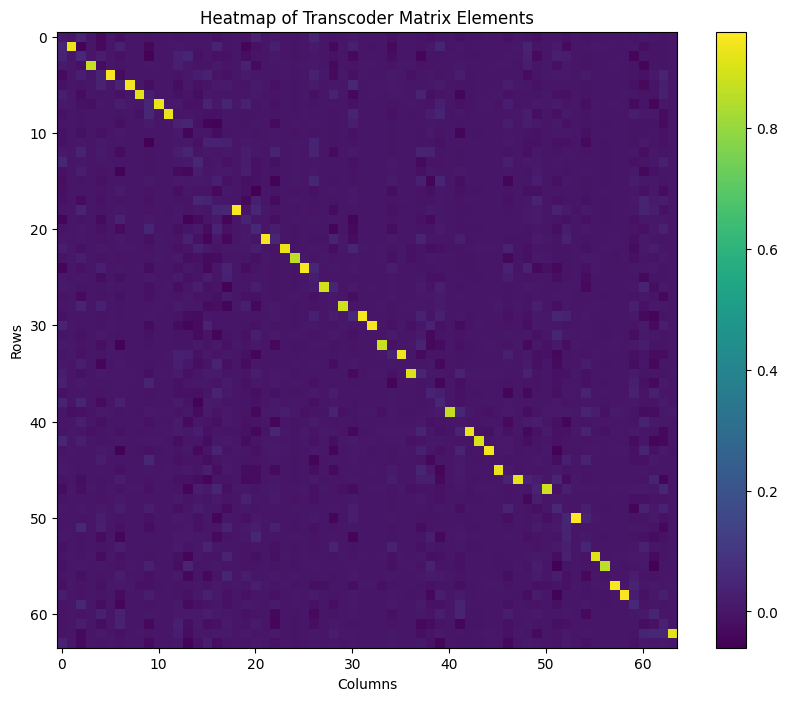

In [39]:
plt.figure(figsize=(10, 8))
plt.imshow(shuffled_trans_mat, cmap='viridis', aspect='auto')
plt.colorbar() 
plt.title("Heatmap of Transcoder Matrix Elements")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()

But it's not a perfect picture! The transcoder here hasn't learned an exactly one-to-one map from SAE1 to SAE2. 

Why not? 

It's because (at least when this cell was written) there were more dictionary features in SAE1 and SAE2 than in the ground truth. This means some dictionary features should be considered 'dead', but they'll appear in this matrix anyway. We'll remove them in the next bit.

What we'll do is 
1. find out which features should be considered 'dead' by collecting the activations for each feature in SAE1 and SAE2 and summing them together. Features that should be 'dead' will have a small sum because they'll have been activated less often.
2. Remove the dead features from the analysis

In [40]:
# Get an estimate of which features are dead features in both SAEs
# The batch size is large so we'll just collect the sum of the activations of each neuron over the whole batch

total_acts1 = None
total_acts2 = None

for i in range(20):
    batch = next(data_generator)
    Mbatch = batch @ M

    # Forward pass of each autoencoder and the transcoder
    with torch.no_grad():
        x_hat1, c1 = auto_encoder1(batch)
        x_hat2, c2 = auto_encoder2(Mbatch)

    if total_acts1 is None:
        total_acts1 = c1.sum(axis=0).cpu().numpy()
        total_acts2 = c2.sum(axis=0).cpu().numpy()
    else:
        total_acts1 += c1.sum(axis=0).cpu().numpy()
        total_acts2 += c2.sum(axis=0).cpu().numpy()



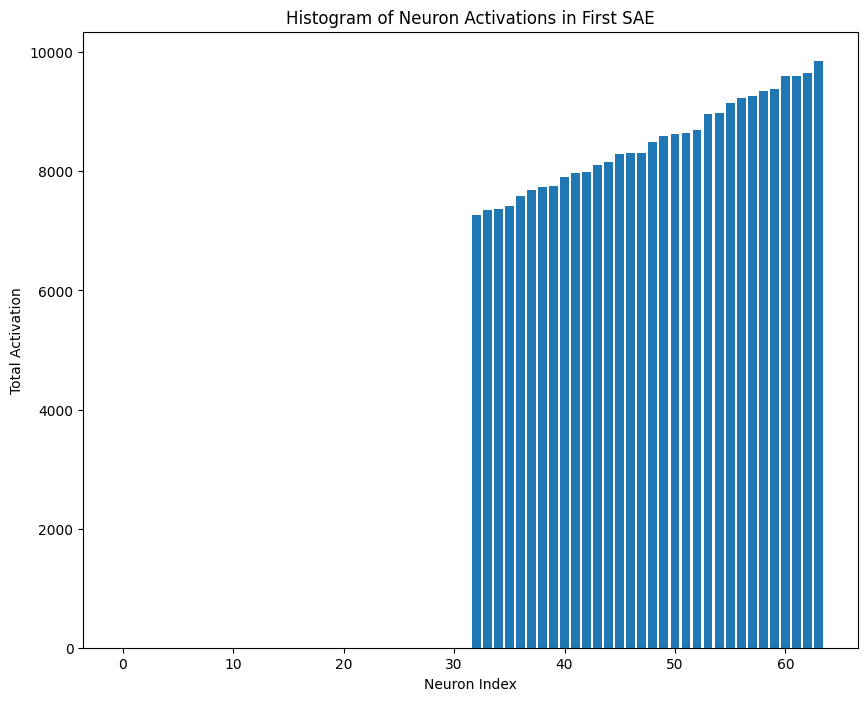

In [41]:
# For the first SAE, plot a histogram of the activations of each neuron over the whole batch, sorted by the activations
plt.figure(figsize=(10, 8))
plt.bar(range(cfg.n_components_dictionary), np.sort(total_acts1))
plt.title("Histogram of Neuron Activations in First SAE")
plt.xlabel("Neuron Index")
plt.ylabel("Total Activation")
plt.show()


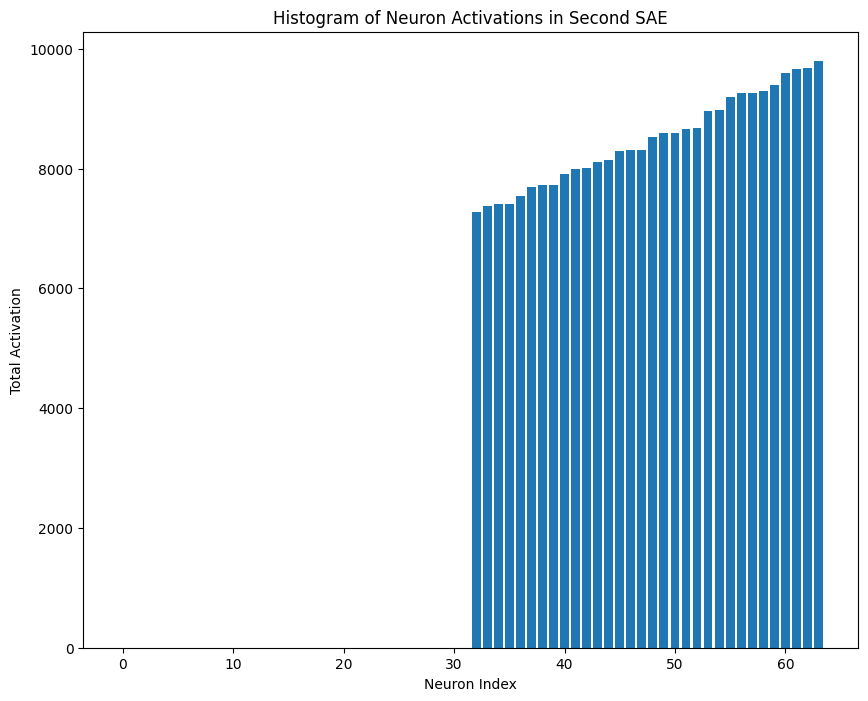

In [42]:
# Now the second SAE
plt.figure(figsize=(10, 8))
plt.bar(range(cfg.n_components_dictionary), np.sort(total_acts2))
plt.title("Histogram of Neuron Activations in Second SAE")
plt.xlabel("Neuron Index")
plt.ylabel("Total Activation")
plt.show()


Clearly the ones with zero activation are dead. So we'll remove them from analysis and make a 'truncated' transcoder matrix.

In [43]:
# Now plot the transcoder matrix elements sorted by the activations of the first SAE neurons
acts_sort1 = np.argsort(total_acts1)
acts_sort2 = np.argsort(total_acts2)

# Here, because we know the number of ground truth features, we can just take the top half,
# since there are twice as many dictionary elements as ground truth features in the config. 
# But in general, we won't know the number of ground truth features, so we can just cut the 
# dead neurons. We do it this way so that it's easier to compare the last plot between the 
# L1 case (which leaves some features alive unneccessarily) and the L0.5 case (which kills 
# all the features that are dead in both SAEs)
half_num_features = len(acts_sort1)//2 # See comment
trunc_trans_mat = trans_mat[:, acts_sort1[half_num_features:]]
trunc_trans_mat = trunc_trans_mat[acts_sort2[half_num_features:], :]



In [44]:
# Get the indices that would sort the max feature-feature coefficients for each feature 
trunc_maxes = trunc_trans_mat.argmax(axis=0)
trunc_sort_indices = np.argsort(trunc_maxes)

# Sort the columns of trans_mat
trunc_shuffled_trans_mat = trunc_trans_mat[:, trunc_sort_indices]


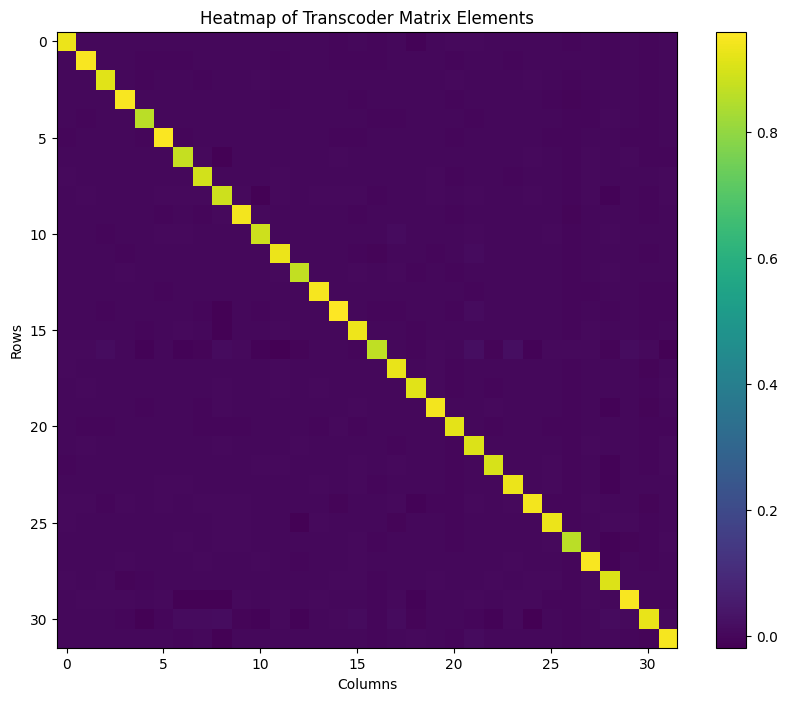

In [45]:
# Plot a heatmap of the rearranged transcoder matrix elements with matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(trunc_shuffled_trans_mat, cmap='viridis', aspect='auto') 
plt.colorbar()
plt.title("Heatmap of Transcoder Matrix Elements")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()

There is a nice one-to-one correspondence between features! This is exactly what we'd want from a method that is invariant to linear transformations.

Now you should go to the start and run it again, changing the p-norm to either 1 or 0.5 (whichever you haven't seen yet). You'll notice that with the L1 norm, there are much fewer dead features than with a smaller p-norm. L1 doesn't force the network to choose between activating two identical features - it lets them both activate. L_0.5 (for example) encourages the network to choose one feature and kill the other. This leads to messier plots for L1 than with L_0.5.